<a href="https://colab.research.google.com/github/Lenadeu/Time-series-anomaly-detection/blob/main/Kmeans_period_from_autocorrelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install psutil
#pip install numpy
#pip install matplotlib
#pip install scikit-learn
#pip install kmeanstf
#pip install tensorflow-gpu
#!pip install tslearn
#!pip install netdata_pandas
#!pip install am4894plots
!pip install minisom
!pip install tslearn
!pip install quantecon
!pip install nitime


  Created wheel for minisom: filename=MiniSom-2.2.9-py3-none-any.whl size=8595 sha256=92373e80be5bfdd25d54e8958ac8f4c95d2f7d96c1b3ae0754733cd778e79897
  Stored in directory: /root/.cache/pip/wheels/3d/a1/10/f50b6f4865652eac239a2700de411c3078c27e1318320e494c
Successfully built minisom
     |████████████████████████████████| 793 kB 14.3 MB/s 
     |████████████████████████████████| 269 kB 14.6 MB/s 
     |████████████████████████████████| 6.2 MB 13.0 MB/s 
  Created wheel for nitime: filename=nitime-0.9-cp37-cp37m-linux_x86_64.whl size=4032177 sha256=f9d34db0d469e6657a909d0125497bff838f44994fd32b3ecef4edb05ff4d574
  Stored in directory: /root/.cache/pip/wheels/8e/1b/71/d7d584087121ac331c444b913abeb116b527dad2a0f1d9157a
Successfully built nitime


In [ ]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

import seaborn as sns
import tensorflow as tf

In [ ]:
def make_collection_from_time_series(time_series_df,window_size=100):
  time_series_collection = []
  #number of series in collection 
  series_num=int(len(time_series_df)/window_size)
  #left index 
  l_ind=0
  #right index 
  r_ind=window_size
  for i in range(series_num):

        data_chunk=time_series_df.values[l_ind:r_ind]
        index = [x for x in range(window_size)]

        #print('data_chunk type',type(data_chunk))
        ##print('data_chunk shape',np.shape(data_chunk))
        
        #print('index type',type(index))
        #print('index shape',np.shape(index))
        

        df = pd.DataFrame(data_chunk,index=index,columns=['Data']) 

        #print('data chunk shape',np.shape(df))
        #print('l_ind',l_ind)
        #print('r_ind',r_ind)
        

        # While we are at it I just filtered the columns that we will be working on
        #df.set_index("date",inplace=True)
        # ,set the date columns as index
        ##df.sort_index(inplace=True)
        # and lastly, ordered the data according to our date index
        time_series_collection.append(df)



        #shift indexes  
        l_ind = r_ind
        r_ind = l_ind+window_size

  return time_series_collection
        

In [ ]:
#splitting indexes between train and test data from files  
def get_splitting_ind_from_file(filename):
    
   
    split_ind = -1000000000
     
    #get extention 
    ext = os.path.splitext(filename)[-1].lower()
    
    #print('ext=',ext)

    #if extention is not "txt" then return nothing
    if ext != ".csv":
        return '',''
    
    #get index of splitting from train to test from file name 
    split_ind_t = os.path.basename(filename).split('_')[3]
    split_ind=(int(split_ind_t[:-4]))
    
    
    
    return split_ind

In [ ]:
#get train and test data for all series 
def get_train_test_data(time_series,split_ind):
   # test_data = []
    #train_data = []
    
    train_data=time_series[0:split_ind]

    test_data=time_series[split_ind+1:-1]

    return test_data,train_data

In [ ]:
def is_accurate(pred: int, start: int, end: int) -> bool:
    """Compute whether a prediction is accurate enough

    Args:
        pred (int): predicted time series step of the center of the anomaly
        start (int): true start of anomaly
        end (int): true end of anomaly

    Returns:
        bool: prediction is accurate
    """
    accepted_inaccuracy = 100  # slack for short anomalies
    length_anomaly = end - start + 1
    if (
        min(start - length_anomaly, start - accepted_inaccuracy)
        < pred
        < max(end + length_anomaly, end + accepted_inaccuracy)
    ):
        return True
    else:
        return False

In [ ]:
# Draw Plot for pandas data frame using pyplot 
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [ ]:
def dB(x, out=None):
    if out is None:
        return 10 * np.log10(x)
    else:
        np.log10(x, out)
        np.multiply(out, 10, out)

In [ ]:
def period_estimation(time_series_val):
   
    import scipy.signal as sig
    import scipy.stats.distributions as dist

    import nitime.algorithms as tsa
    import nitime.utils as utils
    from nitime.viz import winspect
    from nitime.viz import plot_spectral_estimate

    from quantecon import ARMA, periodogram, ar_periodogram

    #
    ln2db = dB(np.e)
   
    # Remove constant component 
    time_series_val_noDC = time_series_val-time_series_val.mean()
    
    # This is the true PSD for this sequence:
    #fgrid, hz = tsa.freq_response(1.0, a=np.r_[1, -alpha], n_freqs=N)
    #psd = 0
    
    # This is a one-sided spectrum, so we double the power:
    #psd *= 2
    #dB(psd, psd)

    #
    freqs, d_psd = periodogram(time_series_val_noDC)

    print('freq',freqs)
    print('psd',d_psd)
    #dB(d_psd, d_psd)

    #fig03 = plot_spectral_estimate(freqs, psd, (d_psd,), elabels=("Periodogram",))
   

    fig, ax = plt.subplots()
    ax.plot(freqs, d_psd, 'b-', lw=2, alpha=0.8, label='periodogram')
    ax.legend()
    plt.show()


    max_psd=max(d_psd)


    idx = np.where(d_psd == max_psd)[0][-1]

    print('idx',idx)

    max_f = abs(freqs[idx])

    print('max freq',max_f)

    period=int(np.ceil(1/max_f)*100) 

    print("The period is ",period)

    return period





In [ ]:
def evaluation_time_series(series_filename,real_anomaly_start,real_anomaly_end):
    
    #for plotting with seaborn ############
    sns.set()
    #######################################
    
    #window for searching anomaly 
    Anomaly_search_Window = 100
    
    #file with data  
    #print("file name = ",series_filename)
    path="drive/MyDrive/Colab Notebooks/AILab/Data_excel/"
    
    # get time series from the file
    time_series_df = pd.read_csv(path+os.path.join(series_filename),parse_dates=['Date'], index_col='Date')

    time_series_df.head()

    print(time_series_df)


    fig, ax = plt.subplots()
    ax.plot(time_series_df.values)
    plt.title('initial series')



    ############            get period with autocorrelation

     
   
    autocor = []
    bunches = []
    this_bunch = []
    for i_lag in range(len(time_series_df.values)):
        if i_lag > 0.25: 
            ac = time_series_df['Data'].autocorr(lag=i_lag)
            autocor.append(ac)
            if ac < 0.25:
                if this_bunch:
                    bunches.append(this_bunch.copy())
                    this_bunch = []
            else:
                this_bunch.append(ac)

    fig1, ax1 = plt.subplots()  
  
    ax1.plot(bunches[1])
    ax1.plot(bunches[2])
    plt.show()

    P = autocor.index(max(bunches[2])) - autocor.index(max(bunches[1]))
    ax1.plot(autocor)
    plt.show()
    print('Period autocorrelation',P)

    #####################################################

    #test-train split 
    split_ind=get_splitting_ind_from_file(series_filename)
    print('split index',split_ind)

    #period 
    window_size=P
    

    #cut time series on chunks of the period  
    time_series_collection=make_collection_from_time_series(time_series_df,window_size)
   
    # look at our data
    print("time series_collection shape",np.shape(time_series_collection))
    shape_to_list=list(np.shape(time_series_collection))
    
    print('shape_to_list',type(shape_to_list))
    #time_series_collection.head()

    collection_len=shape_to_list[0]
    one_series_len=shape_to_list[1]

    np.reshape(time_series_collection, (shape_to_list[0],shape_to_list[1]))
    print("time series_collection shape",np.shape(time_series_collection))
    
    #data chunks 
    fig2, ax2 = plt.subplots()
    
    #
    for i in range(collection_len):
        ax2.plot(time_series_collection[i][:])
    
    plt.title('collection of a time series chunks')

    #split into train - test 
    #train_df = time_series_df[0:split_ind]
    #test_df = time_series_df[split_ind:]

    # normalization 
    for i in range(collection_len):
        scaler = MinMaxScaler()
        time_series_collection[i] = MinMaxScaler().fit_transform(time_series_collection[i])
        time_series_collection[i]= time_series_collection[i].reshape(one_series_len)
    ########################

    #plot normalized data 

    #data chunks 
    fig3, ax3 = plt.subplots()
    
    #
    for i in range(collection_len):
        ax3.plot(time_series_collection[i][:])
    
    plt.title('normalized collection of a time series chunks')




    ##########################          Kmeans clustering 

    cluster_count = math.ceil(math.sqrt(collection_len)) 
    # A good rule of thumb is choosing k as the square root of the number of points in the training data set 
    print('number of clusters',cluster_count)

    
    #distance metric : {“euclidean”, “dtw”, “softdtw”} (default: “euclidean”)
    #If Dynamic Time Warping “dtw”, DBA is used for barycenter computation.
    #DBA stands for Dynamic Time Warping Barycenter Averaging. 
    #DBA is an averaging method that is consistent with Dynamic Time Warping
    km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")
    #?
    print('km',km)

    #get all data chunks clustered 
    labels = km.fit_predict(time_series_collection)
    #index of cluster for each data chunk 
    print('labels of each data chunck',labels)

    #
    som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(time_series_collection))))
    # I didn't see its significance but to make the map square,
    # I calculated square root of map size which is 
    # the square root of the number of series
    # for the row and column counts of som

    ################# clusters plotting 
    plot_count = math.ceil(math.sqrt(cluster_count))
    fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
    fig.suptitle('Clusters')
    row_i=0
    column_j=0
    # For each label there is,
    # plots every series with that label    
    for label in set(labels):
        cluster = []
        for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(time_series_collection[i],c="gray",alpha=0.7)
                cluster.append(time_series_collection[i])
        #average in red 
        if len(cluster) > 0:
            axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
            axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
            column_j+=1
        if column_j % plot_count == 0:
            row_i+=1
            column_j=0
        
    plt.show()

    ###########################################################################

    ################### clusters distribution plotting 

    #value of cluster = how many data chunks are inside 
    cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
    #index of cluster in string form 
    cluster_n = ["cluster_"+str(i) for i in range(cluster_count)]

    plt.figure(figsize=(15,5))
    plt.title("Cluster Distribution for KMeans")
    plt.bar(cluster_n,cluster_c)
    plt.show()

    #labels values - number of cluster 
    #labels index - number of data chunk 
    train_data_clusters_numbers=[]
    #test_data_ind=[]

    #find numbers of clusters which belong to train set 
    for i in range(len(labels)):
        #location of data chunk in time series 
        chunk_loc = i*window_size
        #if chunk in test set - save its cluster index for future  
        if chunk_loc < split_ind:
            train_data_clusters_numbers.append(labels[i])
            #test_data_ind.append(i)

    print('numbers of clusters of train data',train_data_clusters_numbers)   
    #print('indexes of clusters in initial labels list',test_data_ind) 

    #look for a cluster with minimum data chunks in it excluding the clusters which are in train data 
    min_cluster_val = 100000
    min_cluster_loc = 0
    min_cluser_num = -1 
    
    for i in range(len(labels)):
        #3 not in [2, 3, 4]
        #exclude labels for train data 
        if (labels[i] not in train_data_clusters_numbers):
            #print('label=',labels[i])
            if cluster_c[labels[i]] < min_cluster_val:   
                min_cluster_val = cluster_c[labels[i]]
                #print('min cluster val',min_cluster_val)
                min_cluster_loc = i
                #print('min cluster loc in time series',min_cluster_loc)
                min_cluster_number=labels[i]
                #print('min cluster number',min_cluster_number)
                
                
    print('min cluster value',min_cluster_val)

    print('min cluster loc',min_cluster_loc)
    
    print('min cluster number',min_cluster_number)

    anomaly_ind_predicted=int(min_cluster_loc*window_size+window_size/2)

    print('anomaly_ind_predicted',anomaly_ind_predicted)

    
    print('real anomaly start',real_anomaly_start)
    
    print('real anomaly end',real_anomaly_end)
        
    
    ########################### evaluate 
    return is_accurate(anomaly_ind_predicted, real_anomaly_start,real_anomaly_end)
    

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Feb  7 07:48:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
meta_data_link='https://drive.google.com/file/d/1fReFeSTm3Kf2gUyQ_tC-zLjkRBp5zdjd/view?usp=sharing'

In [ ]:
split = meta_data_link.split('/')
id=split[-2]
print (id) #

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
meta_data_df = pd.read_csv('Filename.csv')
# Dataset is now stored in a Pandas Dataframe

#meta data 
meta_data_df.head()

print('anomaly start',meta_data_df['anomaly_start'])
print('anomaly end',meta_data_df['anomaly_end'])


1fReFeSTm3Kf2gUyQ_tC-zLjkRBp5zdjd
anomaly start 0       52000
1       56600
2       46600
3        5400
4        5391
        ...  
245    270800
246    121900
247      4702
248      8285
249      7290
Name: anomaly_start, Length: 250, dtype: int64
anomaly end 0       52620
1       56900
2       46900
3        5600
4        5392
        ...  
245    271070
246    121980
247      4707
248      8315
249      7296
Name: anomaly_end, Length: 250, dtype: int64


In [ ]:
# Get the list of all files 
# in the directory Data_excel
data_dir_link = "https://drive.google.com/drive/folders/1YbhV3K6VTNJn10joLIc8FmX2UXbj1V_v?usp=sharing"

split1 = data_dir_link.split('/')
id=split1[-1]

print(id)

split2 = id.split('=')

id2 = split2[-2]

print(id2)


# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

import os
os.listdir()

data_files = os.listdir('drive/MyDrive/Colab Notebooks/AILab/Data_excel')



1YbhV3K6VTNJn10joLIc8FmX2UXbj1V_v?usp=sharing
1YbhV3K6VTNJn10joLIc8FmX2UXbj1V_v?usp
Mounted at /content/drive


Files with data ['047_UCR_Anomaly_18000.csv', '060_UCR_Anomaly_22000.csv', '066_UCR_Anomaly_3700.csv', '070_UCR_Anomaly_17555.csv', '082_UCR_Anomaly_70000.csv', '086_UCR_Anomaly_20000.csv', '089_UCR_Anomaly_100000.csv', '113_UCR_Anomaly_4000.csv', '116_UCR_Anomaly_4000.csv', '118_UCR_Anomaly_4000.csv', '127_UCR_Anomaly_5000.csv', '140_UCR_Anomaly_1000.csv', '153_UCR_Anomaly_14000.csv', '170_UCR_Anomaly_18500.csv', '174_UCR_Anomaly_3700.csv', '175_UCR_Anomaly_5200.csv', '195_UCR_Anomaly_17000.csv', '196_UCR_Anomaly_20000.csv', '216_UCR_Anomaly_37216.csv', '233_UCR_Anomaly_18913.csv', '237_UCR_Anomaly_19313.csv', '246_UCR_Anomaly_100211.csv', '205_UCR_Anomaly_9812.csv', '208_UCR_Anomaly_5130.csv', '032_UCR_Anomaly_1000.csv']
file ids [47, 60, 66, 70, 82, 86, 89, 113, 116, 118, 127, 140, 153, 170, 174, 175, 195, 196, 216, 233, 237, 246, 205, 208, 32]
metadata of files from phase 1      data_id                        name  ...  anomaly_start  anomaly_end
31        32  DISTORTEDInternalBlee

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


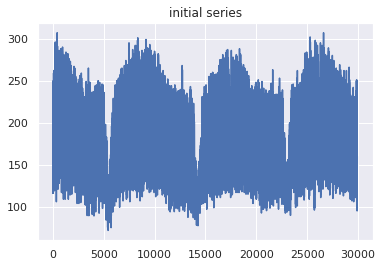

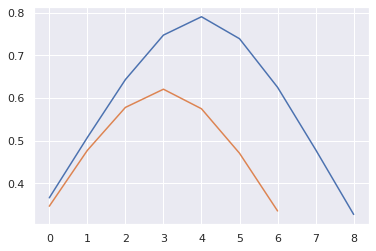

Period autocorrelation 24
split index 18000
time series_collection shape (1247, 24, 1)
shape_to_list <class 'list'>
time series_collection shape (1247, 24, 1)
number of clusters 36
km TimeSeriesKMeans(metric='dtw', n_clusters=36)
labels of each data chunck [23 35 35 ...  3 33  5]


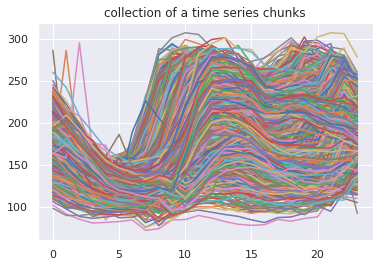

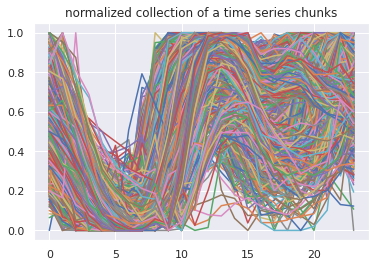

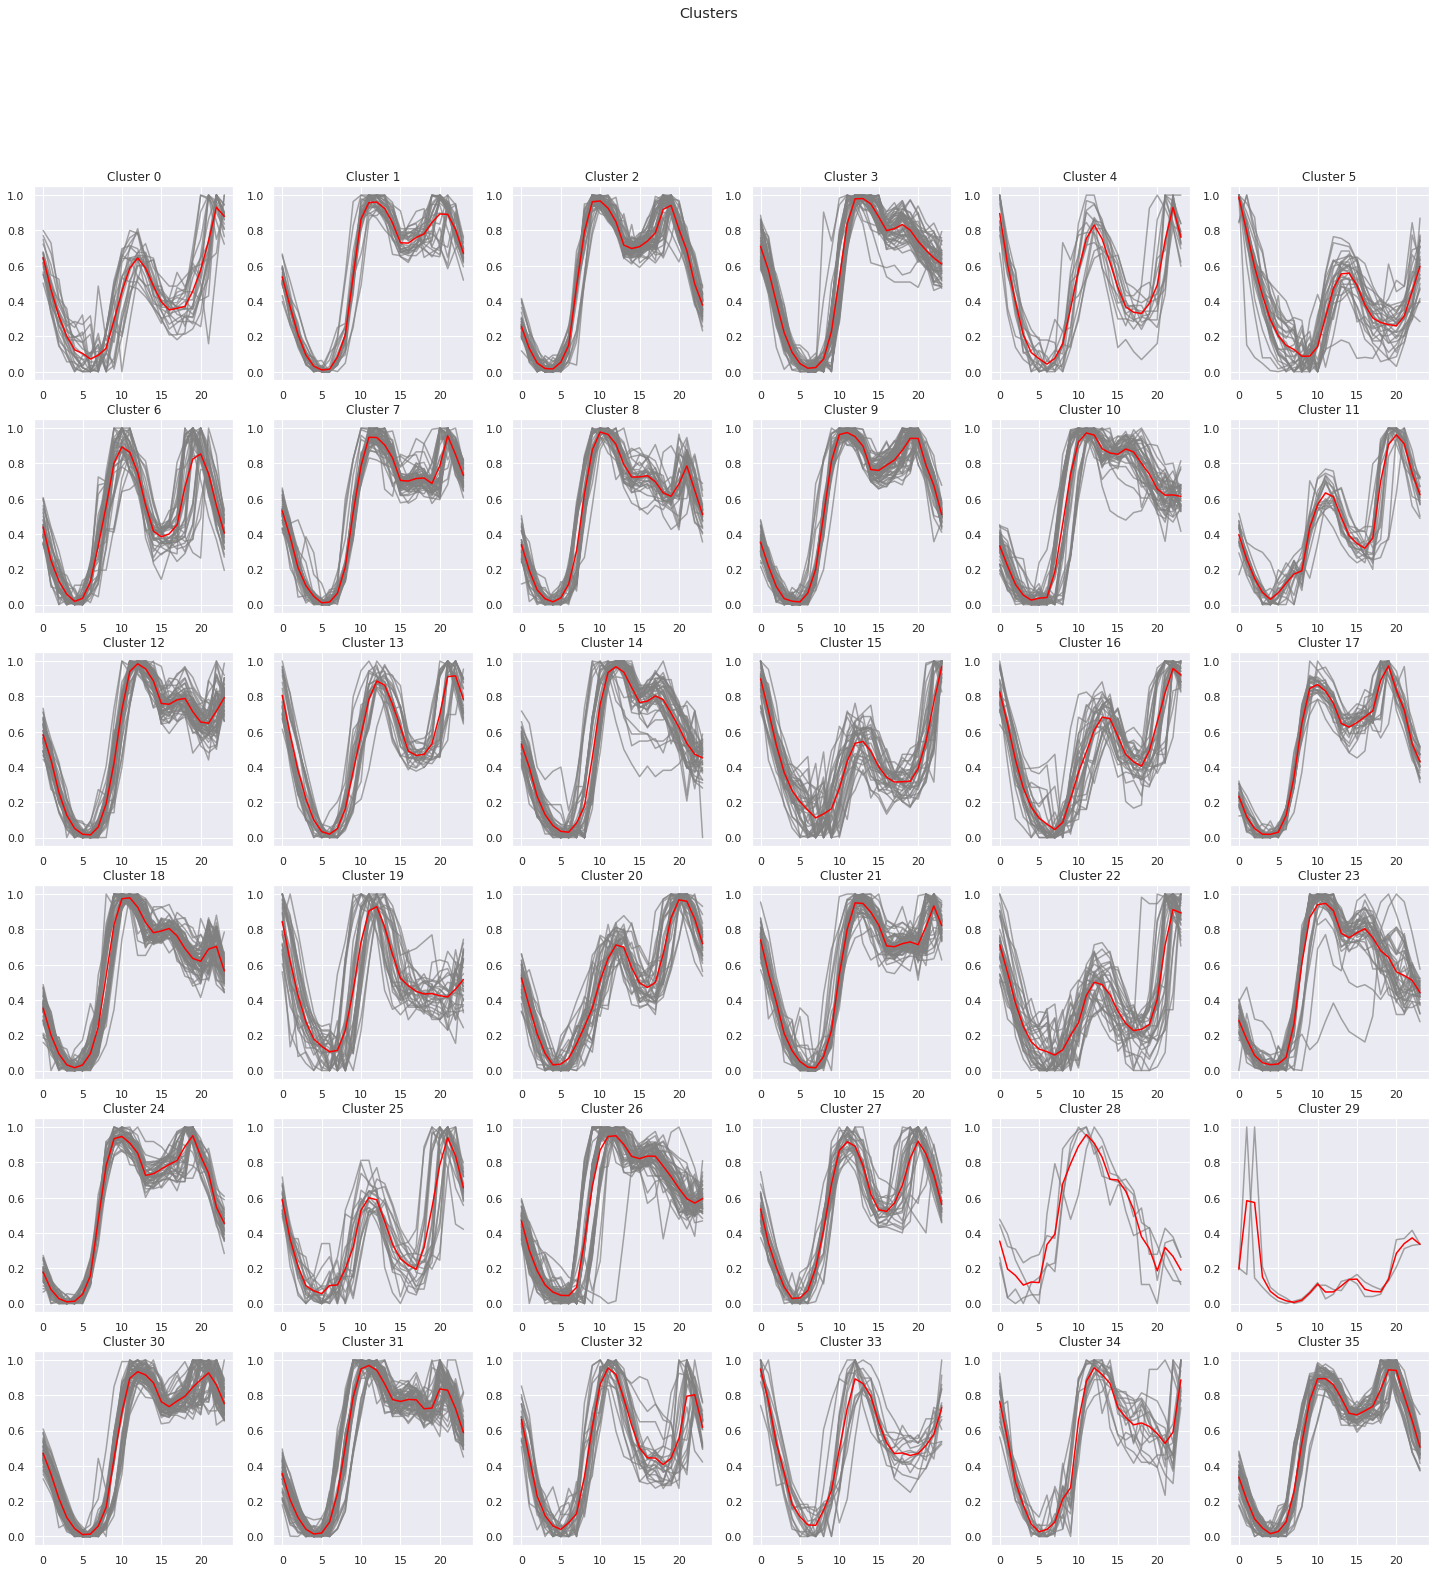

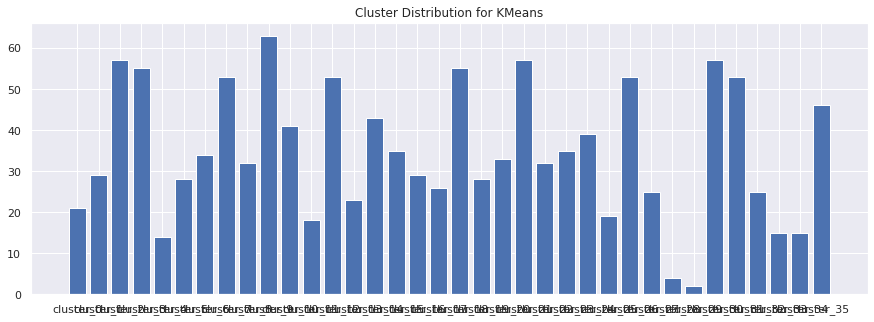

numbers of clusters of train data [23, 35, 35, 24, 35, 25, 20, 11, 24, 2, 2, 2, 2, 6, 20, 24, 24, 2, 2, 2, 6, 20, 24, 2, 2, 24, 2, 6, 11, 2, 2, 2, 2, 2, 6, 11, 2, 2, 2, 2, 2, 6, 11, 9, 2, 2, 2, 24, 6, 11, 35, 24, 9, 2, 9, 6, 20, 24, 24, 35, 35, 2, 6, 11, 24, 35, 24, 17, 2, 6, 20, 24, 24, 2, 17, 9, 6, 25, 24, 24, 24, 2, 2, 6, 11, 31, 8, 18, 8, 8, 19, 25, 24, 8, 8, 8, 8, 6, 25, 31, 8, 8, 8, 23, 32, 25, 11, 18, 2, 24, 23, 10, 0, 23, 20, 31, 23, 18, 6, 4, 25, 18, 18, 18, 18, 32, 0, 18, 18, 23, 23, 31, 8, 0, 18, 31, 18, 23, 18, 14, 16, 18, 8, 10, 10, 23, 23, 4, 10, 10, 23, 26, 18, 19, 0, 10, 26, 26, 26, 26, 14, 0, 10, 10, 18, 23, 26, 14, 0, 10, 10, 14, 10, 23, 33, 15, 18, 23, 26, 26, 23, 14, 0, 10, 10, 23, 10, 26, 19, 22, 10, 26, 23, 23, 26, 19, 15, 23, 23, 10, 10, 23, 19, 15, 10, 23, 23, 23, 23, 19, 15, 23, 10, 8, 8, 28, 19, 15, 10, 28, 18, 32, 28, 25, 22, 21, 22, 31, 32, 6, 0, 22, 8, 8, 18, 8, 8, 32, 22, 31, 18, 18, 18, 18, 6, 22, 31, 18, 18, 23, 18, 27, 22, 31, 31, 8, 18, 31, 6, 25, 24, 

UnboundLocalError: ignored

In [ ]:
#from pandas import DataFrame

#print all data files 
print("Files with data", data_files) 


#get the id of files from its names 
file_ids=[]
for i in range(0,len(data_files)):
    split_=data_files[i].split('_')[0]
    file_ids.append(int(split_[0:3]))

print('file ids',file_ids)

#get meta data for phase1 files (there are metadata on all files in metadata.csv)
meta_data_ph1 = meta_data_df[ meta_data_df['data_id'].isin(file_ids) ]

print('metadata of files from phase 1',meta_data_ph1)


#number of the file 
file_num = 0
#id of the file 
file_id = file_ids[file_num]
#file name 
file_name=data_files[file_num]

print('file index',file_num)
print('file id',file_id)
print('file name',file_name)

#metadata of the file 
metadata_of_file_num=meta_data_df[ meta_data_df['data_id'] == file_id ]
print('metadata of the file',metadata_of_file_num)

#real start of anomaly 
anomaly_start_real=metadata_of_file_num['anomaly_start'].values
print('anomaly_start_real',anomaly_start_real)
print(np.shape(anomaly_start_real))
print(np.size(anomaly_start_real))

#real end of anomaly 
anomaly_end_real=metadata_of_file_num['anomaly_end'].values
print('anomaly_end_real',anomaly_end_real)
print(np.shape(anomaly_end_real))
print(np.size(anomaly_end_real))


#evaluate 
#print('file',file_name,'start',anomaly_start_real,'end',anomaly_end_real)

eval_res=evaluation_time_series(file_name,anomaly_start_real,anomaly_end_real)

print('evaluation ',eval_res)
